In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_columns', None)

**Log historical condor job classads every 6 hours with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
attributes="ClusterId,ProcId,ExitStatus,JobStatus,LastJobStatus,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,JobRunCount,RequestMemory,JobStartDate,MATCH_EXP_JOBGLIDEIN_ResourceName,User,Owner,ResidentSetSize_RAW,CumulativeRemoteUserCpu,BytesRecvd,RemoteWallClockTime,NumJobStarts,BytesSent,ExecutableSize_RAW,CumulativeSlotTime,ExitCode,CompletionDate,TransferInputSizeMB,RemoteUserCpu,RequestDisk,RequestCpus,DiskUsage_RAW"
timestamp=$(date +%F_%T_%s | sed -s 's/[-:]//g')
for uafnum in 4 8 10; do
    fname="logs/history_uaf${uafnum}_${timestamp}.txt.gz"
    echo "Writing to $fname"
    earlier=$(($(date +%s) - 6*3600)) # 6 hours
    condor_history -name uaf-${uafnum}.t2.ucsd.edu -since "CompletionDate<${earlier}"  -json -attributes  ${attributes} | gzip -9 > $fname
done
```

In [2]:
def get_condor_df():
    """
    Each gzipped file is just a list of jsons for job classads
    which were taken from condor_history every 6 hours.
    Cache the output in a pickle file
    """
    pkl_fname = "data/df_condor.pkl.bz2"
    if os.path.exists(pkl_fname):
        return pd.read_pickle(pkl_fname)
    fnames = glob.glob("data/condor/logs/*.gz")
    dfs = []
    for fname in tqdm(fnames):
        try: df = pd.read_json(fname)
        except: continue
        dfs.append(df)
    df = pd.concat(dfs).reset_index()
    df.to_pickle(pkl_fname)
    return df

**Log hadoop metrics every 6 hours with a script like**
```bash
#!/usr/bin/env sh
mkdir -p logs
fname="logs/nodes_$(date +%F_%T_%s | sed -s 's/[-:]//g').txt"
echo "Writing to $fname"
echo "Getting hadoop info"
hdfs fsck -locations -blocks -files /cms/store/group/snt/run2_data2018/MET_Run2018D-PromptReco-v2_MINIAOD_CMS4_V10-02-04/ > $fname
echo "Parsing hadoop info to get unique node IPs"
ips=$(grep -oE '[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}\.[0-9]{2,3}:' ${fname} | cut -d ':' -f1 | sort | uniq)
echo "Found $(echo $ips | wc -w) unique node IPs"
echo >> $fname
echo "-------- BEGIN DNS LOOKUP --------" >> $fname
for ip in ${ips} ; do h=$(host -W 1 $ip); echo $ip $h ; done >> $fname
echo "-------- END DNS LOOKUP --------" >> $fname
```

In [3]:
def get_hadoop_df(skip_cache=False):
    """
    Each text file has the output of hadoop fsck as well as a DNS/hostname lookup on the node IPs.
    Cache the output in a pickle file.
    """
    pkl_fname = "data/df_hadoop.pkl"
    if os.path.exists(pkl_fname) and not skip_cache:
        return pd.read_pickle(pkl_fname)
    fnames = glob.glob("data/hadoop/logs/*.txt")
    data = []
    # Strip out t2 suffix
    def parse_dns(x):
        return x.split()[-1][:-1].replace(".t2.ucsd.edu","")
    for fname in fnames:
        dnslines = []
        nodes = None
        in_dns = False
        for line in open(fname,"r"):
            if line.startswith(" Number of data-nodes"): nodes = int(line.split()[-1])
            elif line.startswith("-------- BEGIN DNS LOOKUP"): in_dns = True
            elif line.startswith("-------- END DNS LOOKUP"): in_dns = False
            elif in_dns:
                if ("BEGIN" not in line) and ("timed out" not in line):
                    dnslines.append(line)
        hosts = set(map(parse_dns,dnslines))
        timestamp = int(fname.rsplit("_",1)[1].rsplit(".",1)[0])
        data.append(dict(timestamp=timestamp,hosts=hosts,nodes=nodes))
    df = pd.DataFrame(data)
    df = df.sort_values("timestamp",ascending=True).reset_index()
    # Pairwise set subtractions to get hosts that were added or lost
    df["hosts_gained"] = pd.Series([set()]+map(lambda x:x[0]-x[1], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["hosts_lost"] = pd.Series([set()]+map(lambda x:x[1]-x[0], zip(df.hosts.values[1:],df.hosts.values[:-1])))
    df["nhosts_gained"] = df.hosts_gained.map(len)
    df["nhosts_lost"] = df.hosts_lost.map(len)
    df["nhosts"] = df.hosts.map(len)
    df["date"] = pd.to_datetime(df["timestamp"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")
    df = df.drop(["hosts","timestamp"],axis=1)
    df.to_pickle(pkl_fname)
    return df

In [4]:
df_condor = get_condor_df()
df_hadoop = get_hadoop_df()

100%|██████████| 642/642 [00:28<00:00, 22.75it/s]
/Users/namin/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [5]:
# Historical job ClassAd information
df_condor.head()

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,MATCH_EXP_JOBGLIDEIN_ResourceName,MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot,MATCH_GLIDEIN_Site,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,User
0,0,55837204.0,89595.0,9873627,1555376527,1390,1437,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-4-4-32.t2.ucsd.edu,UCSD,1,bemarsh,354,1390,1437,1,5242880,1024,673072.0,53,bemarsh@t2.ucsd.edu
1,1,55837204.0,89505.0,9873627,1555376503,1359,1419,132782,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_2@cabinet-5-5-18.t2.ucsd.edu,UCSD,1,bemarsh,240,1359,1419,1,5242880,1024,738712.0,53,bemarsh@t2.ucsd.edu
2,2,55837204.0,89555.0,9873627,1555376474,1326,1393,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-1-1-15.t2.ucsd.edu,UCSD,1,bemarsh,193,1326,1393,1,5242880,1024,727556.0,53,bemarsh@t2.ucsd.edu
3,3,55837204.0,89518.0,9873627,1555376445,1310,1367,132783,5,0.0,0,1.0,1.555375e+09,4,2,UCSDT2,slot1_1@cabinet-7-7-2.t2.ucsd.edu,UCSD,1,bemarsh,150,1310,1367,1,5242880,1024,657492.0,53,bemarsh@t2.ucsd.edu
4,4,55837204.0,89618.0,9873627,1555376437,577,645,135136,5,0.0,0,1.0,1.555376e+09,4,2,UCSDT2,slot1_1@sdsc-26.t2.ucsd.edu,UCSD,1,bemarsh,618,577,645,1,5242880,1024,731908.0,53,bemarsh@t2.ucsd.edu


In [6]:
# Information about hadoop node count and sets of gained/lost hosts
# Data is collected in 6 hour intervals
df_hadoop.tail()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date
208,170,182,{},{},0,0,181,2019-05-16 00:01:02-07:00
209,49,182,{},{},0,0,181,2019-05-16 06:01:01-07:00
210,187,182,{},{},0,0,181,2019-05-16 12:01:02-07:00
211,143,182,{},{},0,0,181,2019-05-16 18:01:01-07:00
212,42,178,{},"{cabinet-2-2-7, cabinet-2-2-27, cabinet-2-2-12...",0,4,177,2019-05-16 21:53:23-07:00


In [7]:
# if we scraped too often, we might have double counted, so drop duplicates
df_condor = df_condor[~df_condor.duplicated(["ClusterId","ProcId"],keep="first")]

In [8]:
# Add another column to the hadoop DF which is just the datetime of the previous row (for convenience)
df_hadoop["prev_date"] = df_hadoop.date.shift(1)

In [9]:
# Convert unix timestamps into nice datetime objects
df_condor["CompletionDate"] = pd.to_datetime(df_condor["CompletionDate"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")
df_condor["JobStartDate"] = pd.to_datetime(df_condor["JobStartDate"],unit="s").dt.tz_localize("UTC").dt.tz_convert("US/Pacific")

# Prettier aliases for long classad names
df_condor["site"] = df_condor["MATCH_GLIDEIN_Site"]
df_condor["slot"] = df_condor["MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot"]

# slot1_1@cabinet-4-4-32.t2.ucsd.edu -> cabinet-4-4-32
df_condor["host"] = df_condor["slot"].str.split("@").str[-1].str.replace(".t2.ucsd.edu","")

# blah@t2.ucsd.edu -> blah
df_condor["user"] = df_condor["User"].str.replace("@t2.ucsd.edu","")

# Fraction of CPU (CPU secs / Wall clock / # of CPUs requested for job)
# So fcpu = 1 means the job had 100% cpu usage on 1 core and the user requested 1 core
# fcpu > 1 means user should be requesting more CPUs ;)
df_condor["fcpu"] = df_condor["RemoteUserCpu"]/df_condor["RemoteWallClockTime"]/df_condor["RequestCpus"]

# Disk and memory usage in GB
df_condor["diskGB"] = df_condor["DiskUsage_RAW"]/1.0e6
df_condor["memGB"] = df_condor["ResidentSetSize_RAW"]/1.0e6

# Drop ugly classads
df_condor = df_condor.drop([
    "MATCH_EXP_JOB_GLIDEIN_SiteWMS_Slot",
    "MATCH_GLIDEIN_Site",
    "MATCH_EXP_JOBGLIDEIN_ResourceName",
    "User",
],axis=1)

# Only consider jobs running at UCSD that actually started running (mem usage != 0)
df_condor = df_condor[(df_condor.site.eq("UCSD")) & ~(df_condor["ResidentSetSize_RAW"]==0.)]

In [10]:
df_condor.tail()

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
602197,2121,27500276.0,60296.0,9807532,2019-03-26 13:37:26-07:00,187,611,107940,3,0.0,0,1.0,2019-03-26 13:27:15-07:00,4,2,1,dpgilber,233,187,611,1,5242880,1024,181324.0,26,UCSD,slot1_2@cabinet-4-4-21.t2.ucsd.edu,cabinet-4-4-21,dpgilber,0.306056,0.107940,0.181324
602198,2122,27498956.0,59517.0,9807532,2019-03-26 13:37:24-07:00,82,545,106003,3,0.0,0,1.0,2019-03-26 13:28:19-07:00,4,2,1,dpgilber,344,82,545,1,5242880,1024,2720.0,26,UCSD,slot1_4@cabinet-0-0-27.t2.ucsd.edu,cabinet-0-0-27,dpgilber,0.150459,0.106003,0.002720
602199,2123,27497924.0,60507.0,9807532,2019-03-26 13:37:24-07:00,48,482,105990,3,0.0,0,1.0,2019-03-26 13:29:22-07:00,4,2,1,dpgilber,436,48,482,1,5242880,1024,3580.0,26,UCSD,slot1_5@cabinet-11-11-10.t2.ucsd.edu,cabinet-11-11-10,dpgilber,0.099585,0.105990,0.003580
602200,2124,27503048.0,57047.0,9807532,2019-03-26 13:37:20-07:00,0,407,106050,3,0.0,0,1.0,2019-03-26 13:30:33-07:00,4,2,1,dpgilber,504,0,407,1,5242880,1024,3076.0,26,UCSD,slot1_4@cabinet-0-0-27.t2.ucsd.edu,cabinet-0-0-27,dpgilber,0.000000,0.106050,0.003076
602201,2125,283324160.0,72214.0,9806145,2019-03-26 13:37:18-07:00,12923,10524,2369278,3,0.0,0,1.0,2019-03-26 10:41:54-07:00,4,2,1,sjmay,1459,12923,10524,1,5242880,1024,1721700.0,270,UCSD,slot1_1@sdsc-38.t2.ucsd.edu,sdsc-38,sjmay,1.227955,2.369278,1.721700


In [11]:
df_hadoop.tail()

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date
208,170,182,{},{},0,0,181,2019-05-16 00:01:02-07:00,2019-05-15 18:01:01-07:00
209,49,182,{},{},0,0,181,2019-05-16 06:01:01-07:00,2019-05-16 00:01:02-07:00
210,187,182,{},{},0,0,181,2019-05-16 12:01:02-07:00,2019-05-16 06:01:01-07:00
211,143,182,{},{},0,0,181,2019-05-16 18:01:01-07:00,2019-05-16 12:01:02-07:00
212,42,178,{},"{cabinet-2-2-7, cabinet-2-2-27, cabinet-2-2-12...",0,4,177,2019-05-16 21:53:23-07:00,2019-05-16 18:01:01-07:00


**If the plot below were a flat line, I wouldn't even have made this notebook**

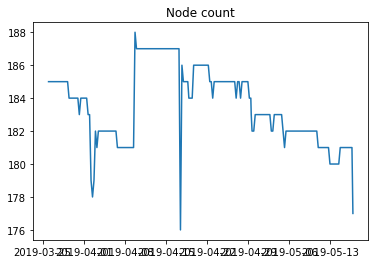

In [59]:
plt.plot(df_hadoop.date,df_hadoop.nhosts)
plt.title("Node count");

In [61]:
# Find intervals of 6 hrs where we gained 0 hosts wrt the previous interval, but lost exactly 1
badrows = df_hadoop.query("nhosts_gained==0 and nhosts_lost>=1")
badrows

,index,nodes,hosts_gained,hosts_lost,nhosts_gained,nhosts_lost,nhosts,date,prev_date
14,147,185,{},{cabinet-0-0-17},0,1,184,2019-03-29 12:01:01-07:00,2019-03-29 06:01:01-07:00
21,63,184,{},{cabinet-7-7-0},0,1,183,2019-03-31 06:01:01-07:00,2019-03-31 00:01:01-07:00
27,150,184,{},{cabinet-4-4-25},0,1,183,2019-04-01 18:01:01-07:00,2019-04-01 12:01:01-07:00
29,110,180,{},"{cabinet-7-7-28, cabinet-7-7-9, cabinet-6-6-5,...",0,4,179,2019-04-02 06:01:01-07:00,2019-04-02 00:01:01-07:00
30,208,179,{},{sdsc-44},0,1,178,2019-04-02 12:01:01-07:00,2019-04-02 06:01:01-07:00
33,72,182,{},{cabinet-7-7-28},0,1,181,2019-04-03 06:01:01-07:00,2019-04-03 00:01:01-07:00
47,4,182,{},{cabinet-2-2-15},0,1,181,2019-04-06 18:01:01-07:00,2019-04-06 12:01:01-07:00
60,163,188,{},{cabinet-7-7-26},0,1,187,2019-04-10 00:01:01-07:00,2019-04-09 18:01:01-07:00
92,204,186,{},{cabinet-7-7-28},0,1,185,2019-04-18 00:01:01-07:00,2019-04-17 18:01:01-07:00
96,207,185,{},{cabinet-4-4-29},0,1,184,2019-04-18 22:22:07-07:00,2019-04-18 18:01:02-07:00


In [64]:
badrows[-1:].hosts_lost.values

array([set(['cabinet-2-2-7', 'cabinet-2-2-27', 'cabinet-2-2-12', 'cabinet-2-2-16'])],
      dtype=object)

In [55]:
# For each "badrow", get all the condor jobs that overlapped with that 6 hour interval
# Concatenate them into a "bad" DF
# Well, they are actually *candidate* "bad" jobs
ndf = []
for idx,row in badrows.iterrows():
    hosts = list(row.hosts_lost)
    df_bad = df_condor[
        # Get df of condor jobs running on that host
        (df_condor.host.isin(hosts)) &
        # EXCLUDE jobs that (completed before the hadoop node check interval) OR (started after the hadoop node check interval)
        ~((df_condor.CompletionDate < row["prev_date"]) | (df_condor.JobStartDate > row["date"]))
    ]
    ndf.append(df_bad)
df_bad = pd.concat(ndf)
df_bad

,index,BytesRecvd,BytesSent,ClusterId,CompletionDate,CumulativeRemoteUserCpu,CumulativeSlotTime,DiskUsage_RAW,ExecutableSize_RAW,ExitCode,ExitStatus,JobRunCount,JobStartDate,JobStatus,LastJobStatus,NumJobStarts,Owner,ProcId,RemoteUserCpu,RemoteWallClockTime,RequestCpus,RequestDisk,RequestMemory,ResidentSetSize_RAW,TransferInputSizeMB,site,slot,host,user,fcpu,diskGB,memGB
14858,207,3502252.0,5489.0,9981323,2019-05-10 21:53:25-07:00,179,2045,58413,5,0.0,0,1.0,2019-05-10 21:19:20-07:00,4,2,1,jguiang,45,179,2045,1,5242880,1024,408576.0,3,UCSD,slot1_6@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.087531,0.058413,0.408576
14861,210,3502252.0,5479.0,9981320,2019-05-10 21:53:20-07:00,272,2261,60815,5,0.0,0,1.0,2019-05-10 21:15:39-07:00,4,2,1,jguiang,83,272,2261,1,5242880,1024,411256.0,3,UCSD,slot1_1@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.120301,0.060815,0.411256
14867,216,3502252.0,5479.0,9981320,2019-05-10 21:52:48-07:00,255,2201,60129,5,0.0,0,1.0,2019-05-10 21:16:07-07:00,4,2,1,jguiang,143,255,2201,1,5242880,1024,413048.0,3,UCSD,slot1_3@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.115856,0.060129,0.413048
14879,228,3502252.0,5497.0,9981322,2019-05-10 21:51:45-07:00,192,1981,60260,5,0.0,0,1.0,2019-05-10 21:18:44-07:00,4,2,1,jguiang,35,192,1981,1,5242880,1024,411752.0,3,UCSD,slot1_6@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.096921,0.060260,0.411752
14880,229,3502252.0,5535.0,9981321,2019-05-10 21:51:45-07:00,195,2034,60298,5,0.0,0,1.0,2019-05-10 21:17:51-07:00,4,2,1,jguiang,146,195,2034,1,5242880,1024,421316.0,3,UCSD,slot1_4@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.095870,0.060298,0.421316
14881,230,3502252.0,5496.0,9981323,2019-05-10 21:51:45-07:00,147,1964,56610,5,0.0,0,1.0,2019-05-10 21:19:01-07:00,4,2,1,jguiang,10,147,1964,1,5242880,1024,412036.0,3,UCSD,slot1_5@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.074847,0.056610,0.412036
14882,231,3502252.0,5497.0,9981322,2019-05-10 21:51:41-07:00,190,1988,59765,5,0.0,0,1.0,2019-05-10 21:18:33-07:00,4,2,1,jguiang,25,190,1988,1,5242880,1024,411768.0,3,UCSD,slot1_5@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.095573,0.059765,0.411768
14945,294,3502252.0,5486.0,9981320,2019-05-10 21:48:28-07:00,251,2015,59542,5,0.0,0,1.0,2019-05-10 21:14:53-07:00,4,2,1,jguiang,2,251,2015,1,5242880,1024,409276.0,3,UCSD,slot1_5@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.124566,0.059542,0.409276
14961,310,3502252.0,5497.0,9981322,2019-05-10 21:48:06-07:00,176,1775,58676,5,0.0,0,1.0,2019-05-10 21:18:31-07:00,4,2,1,jguiang,18,176,1775,1,5242880,1024,412612.0,3,UCSD,slot1_4@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.099155,0.058676,0.412612
15058,407,3502252.0,5497.0,9981322,2019-05-10 21:44:43-07:00,158,1564,57614,5,0.0,0,1.0,2019-05-10 21:18:39-07:00,4,2,1,jguiang,31,158,1564,1,5242880,1024,414360.0,3,UCSD,slot1_2@sdsc-44.t2.ucsd.edu,sdsc-44,jguiang,0.101023,0.057614,0.414360


**Are the above bad jobs too resource intensive?**


Avg cpu fraction for all condor jobs: 0.50
Avg cpu fraction for bad condor jobs: 0.37

Avg disk usage for all condor jobs: 0.67GB
Avg disk usage for bad condor jobs: 1.12GB

Avg memory usage for all condor jobs: 0.88GB
Avg memory usage for bad condor jobs: 1.72GB



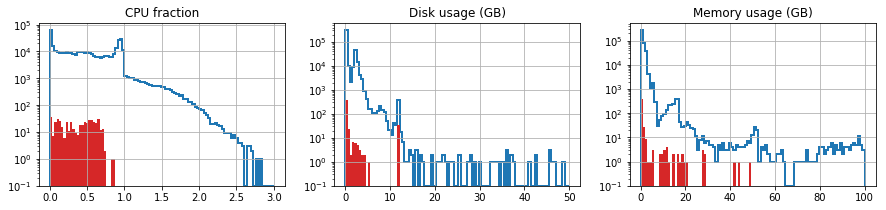

In [33]:
print("Avg cpu fraction for all condor jobs: {:.2f}".format(df_condor["fcpu"].mean()))
print("Avg cpu fraction for bad condor jobs: {:.2f}".format(df_bad["fcpu"].mean()))
print("")
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))
df_condor["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,histtype="step",lw=2)
df_bad["fcpu"].hist(ax=ax1,bins=np.linspace(0,3,100),log=True,color="C3")
ax1.set_title("CPU fraction");

print("Avg disk usage for all condor jobs: {:.2f}GB".format(df_condor["diskGB"].mean()))
print("Avg disk usage for bad condor jobs: {:.2f}GB".format(df_bad["diskGB"].mean()))
print("")
df_condor["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,histtype="step",lw=2)
df_bad["diskGB"].hist(ax=ax2,bins=np.linspace(0,50,100),log=True,color="C3")
ax2.set_title("Disk usage (GB)");

print("Avg memory usage for all condor jobs: {:.2f}GB".format(df_condor["memGB"].mean()))
print("Avg memory usage for bad condor jobs: {:.2f}GB".format(df_bad["memGB"].mean()))
print("")
df_condor["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,histtype="step",lw=2)
df_bad["memGB"].hist(ax=ax3,bins=np.linspace(0,100,100),log=True,color="C3")
ax3.set_title("Memory usage (GB)");

Apparently not. They're similar to other condor jobs on average.

**But, what's going on in general with condor jobs that have >15GB memory usage?! Memory leaks?**

Take high memory usage jobs and separate by username

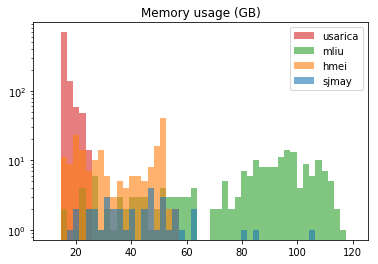

In [34]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["memGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["memGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,120.,50),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("Memory usage (GB)");

**And what about jobs with a CPU fraction > 1?**

Well, for some wiggle room, only check CPU fraction > 120%

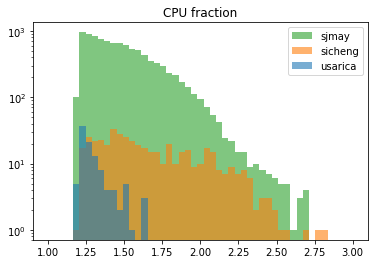

In [35]:
big = df_condor[df_condor["fcpu"]>1.2]
grouped = big.groupby("user")
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
vals = [grouped.get_group(user)["fcpu"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(1.0,3,50),label=users,histtype="stepfilled",alpha=0.6)
ax.set_yscale("log")
ax.legend()
ax.set_title("CPU fraction");

**And jobs that use >15GB of disk?**
I suspect it's the rare foot-shooting where you write a root tree without clearing a vector branch every TTree::Fill()

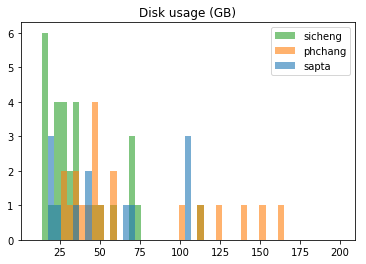

In [36]:
# Select high memory usage jobs and group by the user
big = df_condor[df_condor["diskGB"]>15]
grouped = big.groupby("user")
# Get the size of each group and only plot users that have at least 10 entries in the subsequent histogram
x = grouped.aggregate("size")
users = x[x>10.].sort_values().index.values
# For each of the users, get an array of the memory usage
vals = [grouped.get_group(user)["diskGB"].values for user in users]
fig,ax = plt.subplots()
_ = ax.hist(vals,stacked=False,bins=np.linspace(10.,200.,50),label=users,histtype="stepfilled",alpha=0.6)
# ax.set_yscale("log")
ax.legend()
ax.set_title("Disk usage (GB)");

**Back to the candidate bad jobs. Who are they?**

No clear culprit, and if you submit more condor jobs, you're more likely to show up in the list by chance.

In [37]:
df_bad.groupby("user").size()

user
bemarsh      14
dpgilber      3
hmei         33
jguiang     262
namin        16
phchang       4
sapta       105
sicheng       2
sjmay        37
dtype: int64

In [38]:
fusers_bad = (df_bad.groupby("user").size()/len(df_bad))
fusers_all = (df_condor.groupby("user").size()/len(df_condor))
# Relative ratio of users in bad set wrt full set
(fusers_bad/fusers_all).dropna()

user
bemarsh      0.077997
dpgilber     0.069029
hmei         0.772432
jguiang     14.626012
namin        0.512583
phchang      0.125221
sapta       32.450657
sicheng      0.277808
sjmay        0.521649
dtype: float64

**Actually, something I should have done at the beginning**
is check to see if certain hostnames are more prone to dropping hadoop nodes

(lost nodes might just be governed by bad hardware and not 100% strenuous user activity)

In [39]:
# Get 1D list of lost node hostnames
hosts = pd.Series(df_hadoop["hosts_lost"].map(list).values.sum())
print(hosts)

0       cabinet-0-0-17
1        cabinet-7-7-0
2       cabinet-4-4-25
3       cabinet-7-7-28
4        cabinet-7-7-9
5        cabinet-6-6-5
6        cabinet-7-7-4
7              sdsc-44
8       cabinet-7-7-28
9       cabinet-2-2-15
10      cabinet-7-7-26
11      cabinet-7-7-33
12       cabinet-8-8-2
13      cabinet-4-4-30
14      cabinet-7-7-28
15      cabinet-0-0-23
16      cabinet-4-4-31
17      cabinet-4-4-28
18      cabinet-4-4-29
19      cabinet-0-0-28
20      cabinet-7-7-23
21      cabinet-7-7-31
22      cabinet-7-7-25
23      cabinet-7-7-28
24      cabinet-4-4-29
25             sdsc-16
26       cabinet-7-7-5
27       cabinet-6-6-3
28      cabinet-7-7-22
29       cabinet-7-7-2
30       cabinet-2-2-2
31       cabinet-2-2-0
32       cabinet-7-7-2
33    cabinet-11-11-14
34       cabinet-2-2-4
35      cabinet-2-2-24
36      cabinet-4-4-26
37      cabinet-4-4-28
38             sdsc-44
39      cabinet-1-1-29
40       cabinet-2-2-7
41      cabinet-2-2-27
42      cabinet-2-2-12
43      cab

Maybe the first two numbers give a physical location? Rack/whatever? 
So I'll ignore the 3rd for histogramming purposes. Also ignore those 2 lonely SDSC nodes.

In [40]:
# Pandas vectorized string operations are super neat
badbigcabinet = hosts[hosts.str.contains("cabinet")].str.rsplit("-",1).str[0]
# Fractions of "big cabinet" nodes (cabinet nodes grouped by first 2 numbers)
(badbigcabinet.value_counts()/len(badbigcabinet)).round(3)

cabinet-7-7      0.390
cabinet-2-2      0.220
cabinet-4-4      0.195
cabinet-0-0      0.073
cabinet-6-6      0.049
cabinet-11-11    0.024
cabinet-8-8      0.024
cabinet-1-1      0.024
dtype: float64

**Hmm. cabinet-7-7 is pretty popular.**

What about the distribution of nodes for all condor jobs?

In [41]:
allbigcabinet = df_condor.host[df_condor.host.str.contains("cabinet")].str.rsplit("-",1).str[0]
(allbigcabinet.value_counts()/len(allbigcabinet)).round(3)

cabinet-0-0      0.281
cabinet-5-5      0.220
cabinet-4-4      0.172
cabinet-11-11    0.096
cabinet-7-7      0.078
cabinet-1-1      0.052
cabinet-2-2      0.043
cabinet-8-8      0.037
cabinet-6-6      0.020
cabinet-3-3      0.001
Name: host, dtype: float64

**cabinet-7-7 is not so popular there.**

Taking the ratio, we see that it's 7x overrepresented in the bad set.

In [42]:
((badbigcabinet.value_counts()/len(badbigcabinet))/(allbigcabinet.value_counts()/len(allbigcabinet))).round(3).dropna()

cabinet-0-0      0.260
cabinet-1-1      0.471
cabinet-11-11    0.255
cabinet-2-2      5.092
cabinet-4-4      1.137
cabinet-6-6      2.445
cabinet-7-7      4.980
cabinet-8-8      0.659
dtype: float64

Typically how long are the nodes "out"? Are there bad jobs that knock them out for several hours, or do they stay out for days? 

**Note**: there are a just a handful of instances where we don't get clean pairs to compute "in"-"out" time intervals. Most of them are cases where we lost a hostname and never recovered it.

In [43]:
# Super convoluted, but basically we go through the hadoop dataframe (each row has a single observation
# of which cabinet/sdsc nodes are "in", as well as the list of new nodes "in" since the last 6 hour interval,
# and the list of nodes "out")

# We can find consecutive pairs of out-in instances (i.e., lost hostname foo, then got it back 12 hrs later)
# Store the hostname and the time to recover the hostname as rows in `recoveryinfo`

times = {}
for idx,row in df_hadoop.iterrows():
    if not row.hosts_lost and not row.hosts_gained: continue
    ts_now = row.date
    ts_prev = row.prev_date
    for h in row.hosts_lost:
        if h not in times: times[h] = []
        times[h].append([ts_now,-1])
    for h in row.hosts_gained:
        if h not in times: times[h] = []
        times[h].append([ts_now,1])
recoveryinfo = []
neverrecovered = []
for k,v in times.items():
    def diffs(x):
        # pair of [ts_now, +-1 (delta nodes)]
        (t0now,dn0),(t1now,dn1) = x
        dt = t1now.timestamp()-t0now.timestamp()
        # initially lost, then gained
        dn = 1 if (dn0==-1 and dn1==1) else -1
        return [dt,dn]
    if len(v)>=2:
        ts = times[k]
        pairs = zip(ts[:-1],ts[1:])
        recoveryhours = [round(x[0]/3600.) for x in map(diffs,pairs) if x[1] == 1]
        for rh in recoveryhours:
            recoveryinfo.append([k,rh])
    elif len(v)==1:
        if v[0][1] == -1:
            neverrecovered.append([k, v[0][0]])



Print out the hosts that were lost (and never recovered)

In [44]:
pd.DataFrame(neverrecovered,columns=["host","date"]).sort_values("date").reset_index()

,index,host,date
0,12,cabinet-4-4-25,2019-04-01 18:01:01-07:00
1,1,cabinet-2-2-15,2019-04-06 18:01:01-07:00
2,3,cabinet-8-8-2,2019-04-17 12:01:02-07:00
3,5,cabinet-7-7-23,2019-04-17 12:01:02-07:00
4,8,cabinet-7-7-33,2019-04-17 12:01:02-07:00
5,6,sdsc-16,2019-04-22 12:01:02-07:00
6,10,cabinet-2-2-2,2019-04-29 13:42:50-07:00
7,11,cabinet-2-2-0,2019-04-29 13:42:50-07:00
8,13,cabinet-4-4-26,2019-05-05 00:01:01-07:00
9,7,cabinet-1-1-29,2019-05-13 00:01:01-07:00


Now consider the recovery time of hosts/nodes

In [45]:
df = pd.DataFrame(recoveryinfo,columns=["host","hours"])
df.head()

,host,hours
0,sdsc-44,174.0
1,sdsc-44,90.0
2,cabinet-0-0-23,6.0
3,cabinet-11-11-14,6.0
4,cabinet-0-0-28,6.0


Most recoveries happen within the 6 hour logging interval

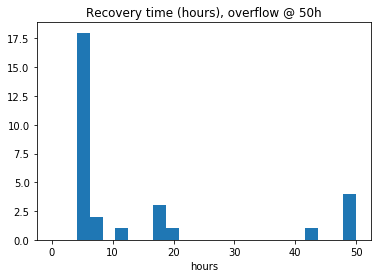

In [46]:
plt.hist(np.clip(df.hours,0,50),bins=np.linspace(0,50,25));
plt.xlabel("hours")
plt.title("Recovery time (hours), overflow @ 50h");

Now separate the previous inclusive histogram based on cabinet-X-X-Y (but sum over Y).
Jitter the points so that overlap doesn't hide the density (2D hists are second-class citizens
in matplotlib and I'm too lazy)

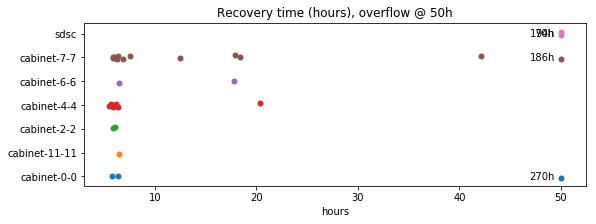

In [47]:
df["bighost"] = df.host.str.rsplit("-",1).str[0].astype("category")
grouped = df.groupby("bighost")
fig,ax = plt.subplots(figsize=(9,3))
for code,host in enumerate(df.bighost.cat.categories):
    hours = grouped.get_group(host)["hours"].values
    for hour in hours[hours>=50.]:
        ax.text(49.4,code,str(int(hour))+"h",va="center",ha="right")
    xfuzz = (2*np.random.random(len(hours))-1)*0.5
    yfuzz = (2*np.random.random(len(hours))-1)*0.1
    ax.scatter(np.clip(hours+xfuzz,0,50),np.array([code for _ in hours])+yfuzz,s=25)
plt.yticks(*zip(*enumerate(df.bighost.cat.categories)));
plt.xlabel("hours")
plt.title("Recovery time (hours), overflow @ 50h");